In [1]:
# Purpose: Create regression maps for ENSO and SAM climate modes and save them 
#          as a .nc file
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
#     Maurice F. Huguenin, m.huguenin-virchaux@unsw.edu.au, 28. 09. 2021      #                                                
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #

# % preamble ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
base = '/g/data/e14/mv7494/access-om2/archive/025deg_jra55_iaf/'
save = '/home/561/mv7494/ENSOAnt_figures/'

import xarray as xr # for working with labelled multi-dimensional arrays                                                                
import numpy as np # for numerical operations                                                           
import string # for subplot annotation                                                                  
import matplotlib.pyplot as plt # for matlab-like plotting                                              
from matplotlib.patches import Rectangle # for shaded rectangle

import cartopy.crs as ccrs # for maps     
from matplotlib import gridspec
from cdo import *
cdo = Cdo()
import os
import sys
import scipy
import warnings
import cmocean as cm
from wrf import to_np # conversion to arrays required for arrows on maps                                
import matplotlib.patheffects as PathEffects
warnings.filterwarnings('ignore') # suppress warnings
from matplotlib import ticker
import nc_time_axis
import time
import cftime
import cartopy.mpl.ticker as cticker
import string # for subplot annotation
import cartopy.feature as cfeature

from dask.distributed import Client
client = Client(n_workers=16)         # careful: do not run with 48 workers here as it will crash
client
rotblau = [[0.4 , 0.  , 0.12], [0.47, 0.02, 0.13], [0.62, 0.07, 0.16], [0.66, 0.16, 0.2],
           [0.8 , 0.3 , 0.27], [0.87, 0.44, 0.35], [0.93, 0.58, 0.45], [0.96, 0.7 , 0.58], 
           [0.98, 0.8 , 0.71], [0.98, 0.94, 0.92], [0.93, 0.95, 0.96], [0.85, 0.91, 0.95],
           [0.76, 0.87, 0.93], [0.64, 0.8 , 0.89], [0.49, 0.72, 0.84], [0.34, 0.62, 0.79], 
           [0.23, 0.53, 0.74], [0.16, 0.44, 0.7] , [0.1 ,0.35, 0.6], [0.05, 0.24, 0.45], [0.02, 0.19, 0.38]]

2022-08-23 13:11:47,937 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/56230178.gadi-pbs/dask-worker-space/worker-g54bqr6y', purging
2022-08-23 13:11:47,937 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/56230178.gadi-pbs/dask-worker-space/worker-bemzipg2', purging
2022-08-23 13:11:47,937 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/56230178.gadi-pbs/dask-worker-space/worker-vg22wjuk', purging
2022-08-23 13:11:47,938 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/56230178.gadi-pbs/dask-worker-space/worker-yynmxlbk', purging
2022-08-23 13:11:47,938 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/56230178.gadi-pbs/dask-worker-space/worker-xyosyjot', purging
2022-08-23 13:11:47,938 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/56230178.gadi-pbs/dask-worker-space/worker-l1d1pezp', purging
2022-08-23 13:11:47,93

### JRA55-do: Create monthly anomaly fields for all input variables

In [2]:
%%time
# ------------------------------------------------------------------------------------------------------------ #
# --- which forcing to use, either JRA55-do-1-3, JRA55-do-1-4-0 or JRA55-do-1-5-0                              #
forcing = '1-3' # 1-4-0                                                                                        #
period = ['1958','2018'] # which period to consider for anomaly calculation                                    #
version = 'v20180412' #'v20190429'                                                                             #
short = 'gn' # 'gr'                                                                                            #
# ------------------------------------------------------------------------------------------------------------ #
base = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-' + forcing + '/'
out = '/g/data/e14/mv7494/JRA55-do-'+forcing+'/'
var = ['huss','psl','tas','ts', 'uas','vas','prra','prsn','rlds','rsds','friver','tos','taux', 'tauy'] # only eight of the variables I used in my Msc

for i in range(len(var)-2): # loop through all variables
    if var[i] in ['huss','psl','tas','ts','uas','vas']: domain = 'atmos/3hrPt/'; timestep = ['01010000','12312100']
    if var[i] in ['prra','prsn','rlds','rsds']:         domain = 'atmos/3hr/';   timestep = ['01010130','12312230']
    if var[i] in ['friver', 'tos']:                     domain = 'ocean/day/';   timestep = ['0101','1231']
    print(domain+var[i]); print('--- --- --- --- ---')

    # filenames for output files
    f1 = out + 'monthly_mean/JRA55-do-'+forcing+'_'+var[i]+'_monthly_mean_'+period[0]+'-'+period[1]+'_detrend.nc'
    f2 = out + 'monthly_anom/JRA55-do-'+forcing+'_'+var[i]+'_monthly_anom_'+period[0]+'-'+period[1]+'.nc'
    if os.path.isfile(f2) == True: # skip iteration if final .nc file already exists
        continue       

# Step I: merge files, create monthly mean fields and detrend
    cdo.detrend(input = '-monmean -mergetime ' + base + domain + var[i] + '/'+short+'/'+version+'/' + 
                var[i] + '_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-' + forcing + '_'+short+'_{' + period[0] + '..' + period[1] + '}*',
                output = f1, force=False)
    # Walltime: 22min 16s for one variable

# Step II: create monthly anomalies
    field = xr.open_dataset(f1)
    (field.groupby('time.month') - field.groupby('time.month').mean('time'))[var[i]].drop('month').to_netcdf(f2) # save as netcdf file

# Step II: create monthly mean and remove that to get the anomalies
#     field = xr.open_dataset(f1)
#     anom = field.groupby('time.month') - field.groupby('time.month').mean('time')
#     anom.to_netcdf(f2) # Wall time: 42.5 s for one field
#     cdo.yseassub(input = f1 +' -yseasavg -selyear,1958/1988 ' + f1, output = f2, force=False)
    
# Step II: also calculating wind stresses
rho_a = 1.25 # kg m$^{-3}$ reference air density at sea level
C_D = 1.5e-3 # unitless drag coefficient (Kara et al. 2007)
uas = xr.open_dataset(out + 'monthly_mean/JRA55-do-'+forcing+'_'+var[4]+'_monthly_mean_'+period[0]+'-'+period[1]+'.nc').uas
vas = xr.open_dataset(out + 'monthly_mean/JRA55-do-'+forcing+'_'+var[5]+'_monthly_mean_'+period[0]+'-'+period[1]+'.nc').vas

print('atmos/3hrPt/taux'); print('--- --- --- --- ---')
(rho_a*C_D*np.sqrt(uas*uas+vas*vas)*uas).to_dataset(name='taux').to_netcdf(out+'monthly_mean/JRA55-do-'+forcing+'_taux_monthly_mean_'+period[0]+'-'+period[1]+'.nc')
print('atmos/3hrPt/tauy'); print('--- --- --- --- ---')
(rho_a*C_D*np.sqrt(uas*uas+vas*vas)*vas).to_dataset(name='tauy').to_netcdf(out+'monthly_mean/JRA55-do-'+forcing+'_tauy_monthly_mean_'+period[0]+'-'+period[1]+'.nc')

# also detrend the wind stress fields and create anomalies
for s in range(2):
    if s == 0: letter = 'x'
    if s == 1: letter = 'y'
    tau1 = out+'monthly_mean/JRA55-do-'+forcing+'_tau'+letter+'_monthly_mean_'+period[0]+'-'+period[1]+'.nc'
    tau2 = out+'monthly_anom/JRA55-do-'+forcing+'_tau'+letter+'_monthly_anom_'+period[0]+'-'+period[1]+'.nc'
    cdo.detrend(input=tau1, output = tau1.replace('.nc','_detrend.nc'), force=False)
    field = xr.open_dataset(tau1.replace('.nc','_detrend.nc'))              # selecting taux or tauy variable
    (field.groupby('time.month') - field.groupby('time.month').mean('time'))[var[s+12]].drop('month').to_netcdf(tau2) # save as netcdf file

# Total Walltime for all 11 vars: 4h 3min 56s
# Wall time: 1min 56s when files already exist

atmos/3hrPt/huss
--- --- --- --- ---
atmos/3hrPt/psl
--- --- --- --- ---
atmos/3hrPt/tas
--- --- --- --- ---
atmos/3hrPt/ts
--- --- --- --- ---
atmos/3hrPt/uas
--- --- --- --- ---
atmos/3hrPt/vas
--- --- --- --- ---
atmos/3hr/prra
--- --- --- --- ---
atmos/3hr/prsn
--- --- --- --- ---
atmos/3hr/rlds
--- --- --- --- ---
atmos/3hr/rsds
--- --- --- --- ---
ocean/day/friver
--- --- --- --- ---
ocean/day/tos
--- --- --- --- ---
atmos/3hrPt/taux
--- --- --- --- ---
atmos/3hrPt/tauy
--- --- --- --- ---
CPU times: user 1min 1s, sys: 14.2 s, total: 1min 15s
Wall time: 1min 8s


### Calculating the N34 index and the idealised N34 polynomial

CPU times: user 25.5 s, sys: 2.03 s, total: 27.5 s
Wall time: 24.3 s


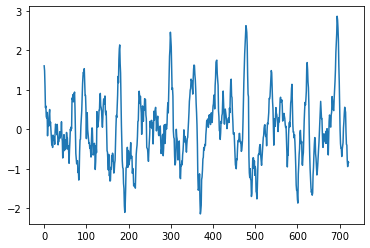

In [3]:
%%time
f11 = out+'monthly_mean/JRA55-do-'+forcing+'_'; f22 = '_monthly_mean_'+period[0]+'-'+period[1]+'.nc'
# remove monthly mean to calculate anomalies
ts = xr.open_dataset(f11 + 'ts' + f22).ts.groupby('time.month') - (xr.open_dataset(f11 + 'ts' + f22).ts.groupby('time.month').mean('time')) 
N34_JRA = ts.isel(lon = slice(339,428)).isel(lat = slice(150,169)).mean(['lat','lon']).load() # N34 region: 5°S-5°N and 170°W-120°W -> -5.335°S ... 5.335°S, 190.1°E ... 240.2°E

# N3_JRA  = ts.isel(lat=slice(150,170)).isel(lon = slice(374,481)).mean(['lat','lon']).load() # N3  region: 5°S-5°N and 150°W-90°W
# N4_JRA  = ts.isel(lat=slice(150,170)).isel(lon = slice(285,375)).mean(['lat','lon']).load() # N4  region: 5°S-5°N and 160°E-150°W
plt.plot(N34_JRA) # Wall time: 26.5 s

### Calculating the spatial SST map and the N34 index for a subplot on the right

CPU times: user 28.6 s, sys: 2.12 s, total: 30.7 s
Wall time: 27 s


Text(0.5, 1.0, 'N34 index = -1.33°C')

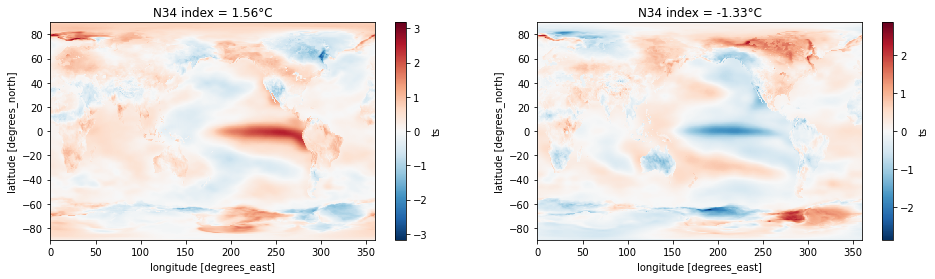

In [4]:
%%time
# top four El Niño events
EN_periods = [168,192,288,312,467,491,683,707]
LN_periods = [168,216,347,395,468,516,612,660] # top four La Niña events

f11 = out+'monthly_mean/JRA55-do-'+forcing+'_'; f22 = '_monthly_mean_'+period[0]+'-'+period[1]+'.nc'
# remove monthly mean to calculate anomalies
anom = xr.open_dataset(f11 + 'ts' + f22).ts.groupby('time.month') - (xr.open_dataset(f11 + 'ts' + f22).ts.groupby('time.month').mean('time'))
# tos_mask = xr.open_dataset('/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-3/ocean/day/tos/gn/v20180412/' + 
#                           'tos_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-3_gn_19910101-19920101.nc').tos[0,:,:]
# tos_mask = tos_mask.fillna(0); tos_mask = tos_mask.where(tos_mask>=0,1).where(tos_mask<=0,1) # replace all NAN with zero and all non-zero data with ones

for f in range(2): # loop through the EN and LN events
    if f == 0: periode = EN_periods; shift = [6,18] # take specific events from the full time series
    if f == 1: periode = LN_periods; shift = [17,28]
    
    SST_map = ((anom[periode[0]+shift[0]:periode[0]+shift[1],:,:].mean('time') + anom[periode[2]+shift[0]:periode[2]+shift[1],:,:].mean('time') + \
        anom[periode[4]+shift[0]:periode[4]+shift[1],:,:].mean('time') + anom[periode[6]+shift[0]:periode[6]+shift[1],:,:].mean('time'))/4).load()
    N34_value = SST_map.isel(lon = slice(339,428)).isel(lat = slice(150,169)).mean(['lat','lon']).load()
    # N34_value = SST_map.sel(lon = slice(190,240)).sel(lat = slice(-5,5)).mean(['lat','lon']).load()
    
    # save data for each iteration
    if f == 0: SST_map_EN = SST_map; N34_value_EN = N34_value # multiply by land-sea mask so that the zero contours are only drawn over the ocean
    if f == 1: SST_map_LN = SST_map; N34_value_LN = N34_value # otherwise zero countours would have been over land as well as the data set is 
                                                                       # ts = temperature surface = combined ocean & land
plt.figure(figsize=(16,4))
plt.subplot(1,2,1); SST_map_EN.plot(); plt.title('N34 index = '+str(np.round(N34_value_EN.values,2))+'°C')
plt.subplot(1,2,2); SST_map_LN.plot(); plt.title('N34 index = '+str(np.round(N34_value_LN.values,2))+'°C')
# Walltime: 21.8 s

In [5]:
SST_map

<xarray.DataArray 'ts' (lat: 320, lon: 640)>
array([[-0.25452495, -0.25498718, -0.25544012, ..., -0.2529859 ,
        -0.25350088, -0.25402382],
       [-0.21173443, -0.212591  , -0.21343856, ..., -0.20931418,
        -0.21012878, -0.21092367],
       [-0.19132404, -0.19263704, -0.19397523, ..., -0.18747881,
        -0.18876164, -0.19004336],
       ...,
       [-0.05176681, -0.05264735, -0.05353406, ..., -0.04807594,
        -0.04931328, -0.05051801],
       [-0.01639554, -0.01663938, -0.01686963, ..., -0.01471052,
        -0.01527366, -0.01582268],
       [ 0.01966685,  0.01951116,  0.01935229, ...,  0.02023387,
         0.0200431 ,  0.01985967]], dtype=float32)
Coordinates:
  * lon      (lon) float64 0.0 0.5625 1.125 1.688 ... 357.8 358.3 358.9 359.4
  * lat      (lat) float64 -89.57 -89.01 -88.45 -87.89 ... 88.45 89.01 89.57

### Plotting routine

CPU times: user 31.5 s, sys: 5.32 s, total: 36.8 s
Wall time: 30.4 s


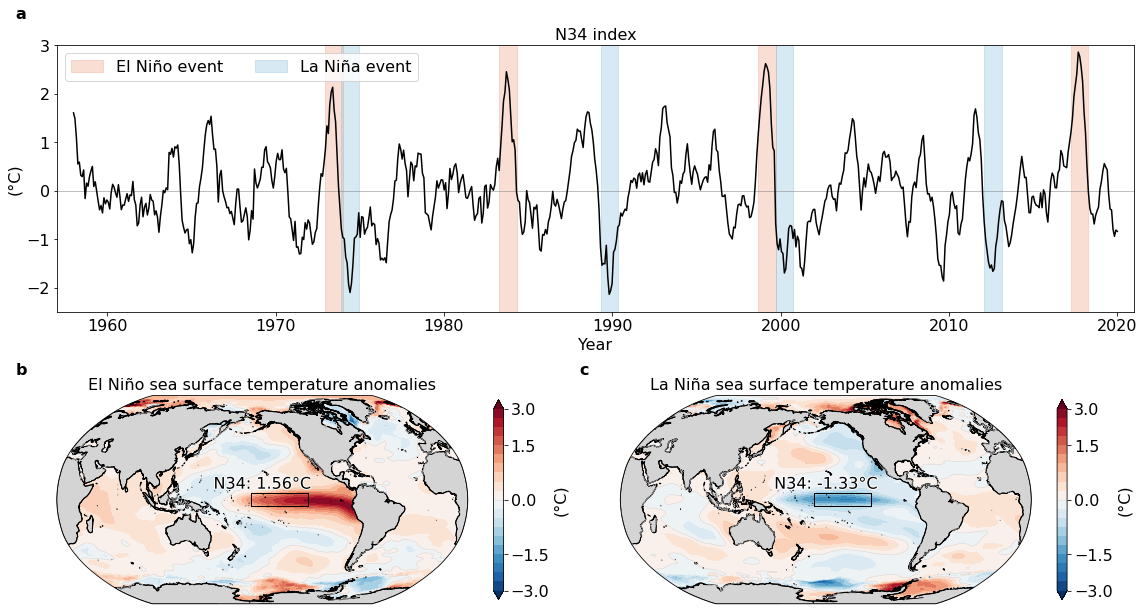

In [6]:
%%time
fig = plt.figure(figsize=(16,9),tight_layout=True,facecolor='w',edgecolor='k'); 
gs = gridspec.GridSpec(2,2, width_ratios=[1,1]) 
ax1 = plt.subplot(gs[0,:]) # long first panel

time = np.linspace(1958,2020,len(N34_JRA)) # I cannot use the .time attribute from the xarray array as using it does not work with ax1.axvspan()

ax1.axhline(0, linewidth=.5, c='grey')

# colour the periods of strong EN & LN
EN_periods = [168,192,288,312,467,491,683,707]; LN_periods = [168,216,347,395,468,516,612,660]
# first doing the shading manually so that I can have figure labels
ax1.axvspan(time[EN_periods[0]+6], time[EN_periods[0]+18], color=rotblau[6], alpha=.3, label='El Niño event')
ax1.axvspan(time[LN_periods[0]+6+11], time[LN_periods[0]+18+11], color=rotblau[14], alpha=.3, label='La Niña event')
for f in [2,4,6]:
    ax1.axvspan(time[EN_periods[f]+6], time[EN_periods[f]+18], color=rotblau[6], alpha=.3)
    ax1.axvspan(time[LN_periods[f]+6+11], time[LN_periods[f]+18+11], color=rotblau[14], alpha=.3)

    
plt.plot(time, N34_JRA, c='k', linewidth=1.5) # plot the data
# plt.plot(time, N3_JRA, c=rotblau[3], label='N3$_\mathrm{{ (5°S-5°N, 150°W-90°W)}}$', linewidth=1.5) # plot the data
# plt.plot(time, N4_JRA, c=rotblau[17], label='N4$_\mathrm{{ (5°S-5°N, 160°E-150°W)}}$', linewidth=1.5) # plot the data
plt.title('N34 index', fontsize=16)

plt.legend(ncol=2,fontsize=16) # figure legend outside
plt.xlim([1957,2021]); plt.ylim([-2.5,3])
plt.ylabel('(°C)', fontsize=16); plt.xlabel('Year', fontsize=16); plt.xticks(fontsize=16); plt.yticks(fontsize=16)

ax1.text(-.038, 1.1,string.ascii_lowercase[0], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top

# second and third panels with SST map ---------------------------------------------- #
for f in range(2):
    if f == 0: panel = gs[1,0]; data = SST_map_EN; N34_value = N34_value_EN; title_str = 'El Niño'
    if f == 1: panel = gs[1,1]; data = SST_map_LN; N34_value = N34_value_LN; title_str = 'La Niña'
    
    ax1 = plt.subplot(panel, projection=ccrs.Robinson(central_longitude=200)) # longitude starting at Cape Agulhas (20°E)
    def fancy_plot(axes_nr):
        axes_nr.coastlines(resolution = '50m', linewidth=1) # add coast lines
        axes_nr.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = [.83, .83, .83], zorder = 1)
        axes_nr.tick_params(axis='both', which='major', labelsize=16) # fontsize of lon/lat labels
    
    # ------------------------------------ #
    p1  = data.plot.contourf(ax=ax1, levels = np.linspace(-2.5,2.5,21), cmp='RdBu_r',add_colorbar=False,extend='both',transform=ccrs.PlateCarree())
    p11 = data.plot.contour(levels = [0], linewidths=.5, cmap='#d4d4d4', transform=ccrs.PlateCarree())
    # ------------------------------------ #                   #d4d4d4 = lightgrey = [.83, .83, .83] in HEX

    # add colour bar   
    cb = plt.colorbar(p1, shrink=.75, orientation='vertical'); 
    cb.set_label(label='(°C)', size=16)
    cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
    cb.locator = tick_locator;cb.update_ticks() 
    cb.add_lines(p11) # add contours to colour bar
    fancy_plot(ax1)

    # # drawing the N34 rectangle
    for r in range(4): # loop through the four sides of the rectangle
        if r == 0: lons = [-170,-120]; lats = [-5, -5] # bottom
        if r == 1: lons = [-170,-120]; lats = [5,   5] # top
        if r == 2: lons = [-170,-170]; lats = [-5,  5] # left
        if r == 3: lons = [-120,-120]; lats = [-5,  5] # right
        txt = plt.plot([lons[0],lons[1]], [lats[0], lats[1]], color = 'black', linewidth=1, transform=ccrs.PlateCarree(),)

    plt.title(title_str + ' sea surface temperature anomalies', size=16)
    txt = plt.text(-160, 12, 'N34: '+str(np.round(N34_value.values,2))+'°C', 
                   verticalalignment='center',transform=ccrs.PlateCarree(), fontsize = 16, horizontalalignment='center') # include N34 value in plot
    txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 
    
    # if f == 0: # add tick labels for °N and °S                                                    # transparent color
    #     grd = ax1.gridlines(draw_labels=True, xlocs=[22,180,0], ylocs=[-60,-30,0,30,60], color='#FF000000')
    #     grd.top_labels = False
    #     grd.xlabel_style = {'size': 16}; grd.ylabel_style = {'size': 16}
 
    ax1.text(-.1, 1.1,string.ascii_lowercase[f+1], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
# --- saving as 300 dpi .PNG image in specified folder ------------- #
filename = 'N34_timeseries_and_spatial_mean_SST_maps_EN_LN'
plt.savefig(save + filename, dpi=300, facecolor='w',                 #
            edgecolor='w', orientation='landscape', papertype=None,  #
            format=None, transparent=False, bbox_inches=None,        #
            pad_inches=0.1, metadata=None)                           #
# --- end of script ------------------------------------------------ # # Wall time: 6.36 s

### Get the idealised time series

In [7]:
time = np.linspace(1,24,24) # time axis of idealised time series
time2 = np.linspace(1,24+22,24+24) # time axis of idealised time series

# top four El Niño events
N34_1972 = N34_JRA.isel(time = slice(EN_periods[0],EN_periods[1])).load() / N34_value_EN # N34 peak in 1972-12 (index 180)
N34_1982 = N34_JRA.isel(time = slice(EN_periods[2],EN_periods[3])).load() / N34_value_EN # N34 peak in 1982-12 (index 300)
N34_1997 = N34_JRA.isel(time = slice(EN_periods[4],EN_periods[5])).load() / N34_value_EN # N34 peak in 1997-11 (index 479)
N34_2015 = N34_JRA.isel(time = slice(EN_periods[6],EN_periods[7])).load() / N34_value_EN # N34 peak in 2015-12 (index 695)
# top four La Niña events
N34_1973 = N34_JRA.isel(time = slice(LN_periods[0],LN_periods[1])).load() / (N34_value_LN*-1) # N34 peak in 1972-12 (index 192)
N34_1988 = N34_JRA.isel(time = slice(LN_periods[2],LN_periods[3])).load() / (N34_value_LN*-1) # N34 peak in 1984-12 (index 370)
N34_1998 = N34_JRA.isel(time = slice(LN_periods[4],LN_periods[5])).load() / (N34_value_LN*-1) # N34 peak in 1997-11 (index 491)
N34_2011 = N34_JRA.isel(time = slice(LN_periods[6],LN_periods[7])).load() / (N34_value_LN*-1) # N34 peak in 2015-12 (index 634)

### Plotting routine idealised time series and SLP + Wind spatial patterns

In [27]:
%%time
import matplotlib.path as mpath 
def fancy_plot(ax):
    ax.gridlines(color='grey', linewidth=1, alpha=1, # dots as grid lines
                  xlocs=range(-180, 180, 60), # longitude grid lines
                  ylocs= np.linspace(-45, -90, num=4)) # latitude grid lines
    ax.coastlines(); # add coast lines
    theta = np.linspace(0, 2*np.pi, 100); center, radius = [0.5, 0.5], .5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    # colour in land and coastlines
    ax.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = [.83,.83,.83], zorder = 1)

CPU times: user 17 µs, sys: 16 µs, total: 33 µs
Wall time: 42.7 µs


CPU times: user 10.8 s, sys: 1.81 s, total: 12.6 s
Wall time: 10.4 s


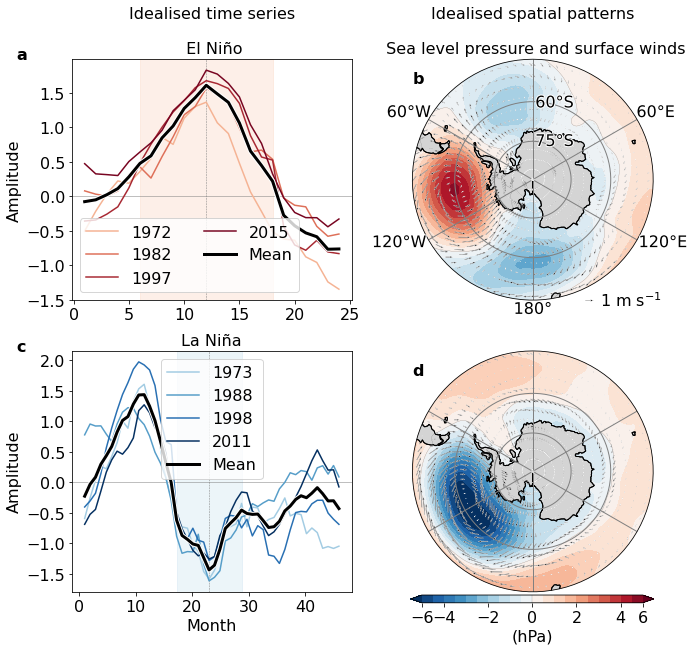

In [28]:
%%time
filename= 'Composite_N34_PC2_time_series_JRA_all_panels'
stand = 0
time = np.linspace(1,24,24) # time axis of idealised time series
time2 = np.linspace(1,24+22,24+24) # time axis of idealised time series
# ------------------------------------------------------------------- #
# initialise figure
fig = plt.figure(figsize=(14,9),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(2, 3, width_ratios=[1,1,1]) 
event = ['El Niño', 'La Niña']
       
# ---------------------------- subplot 1 ---------------------------- #
for f in [0,1,2,4]:
    if f == 0:
        ax1 = plt.subplot(gs[0,0]); plt.axvline(12, linestyle = '--', c = 'grey', linewidth=.5)
        plt.axhline(0, c = 'grey', linewidth=.5)
        plt.plot(time, N34_1972, color=rotblau[7], label='1972')
        plt.plot(time, N34_1982, color=rotblau[5], label='1982')
        plt.plot(time, N34_1997, color=rotblau[3], label='1997')
        plt.plot(time, N34_2015, color=rotblau[1], label='2015')
    if f == 1:
        ax1 = plt.subplot(gs[1,0]); plt.axvline(12+11, linestyle = '--', c = 'grey', linewidth=.5)
        plt.axhline(0, c = 'grey', linewidth=.5)
        plt.plot(time2, N34_1973, color=rotblau[13], label='1973')
        plt.plot(time2, N34_1988, color=rotblau[15], label='1988')
        plt.plot(time2, N34_1998, color=rotblau[17], label='1998')
        plt.plot(time2, N34_2011, color=rotblau[20], label='2011')

    EN_mean = np.zeros(24); LN_mean = np.zeros(24+24)
    for i in range(24):
        EN_mean[i] = (N34_1972[i]+N34_1982[i]+N34_1997[i]+N34_2015[i])/4
    for i in range(24+24):
        LN_mean[i] = (N34_1973[i]+N34_1988[i]+N34_1998[i]+N34_2011[i])/4
    
    if f == 0:
        plt.plot(time, EN_mean, c = 'w', linewidth=5) # white edgecolor
        plt.plot(time, EN_mean, label = 'Mean', c = 'k', linewidth=3)
        # h.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 
        # poly1 = np.poly1d(np.polyfit(time, EN_mean,4))
        # N34_JRA_poly = poly1(time) # new time series constructed from the polynomial
        # plt.plot(time, N34_JRA_poly, linewidth=3, label = '4th order polynomial', color=rotblau[17])
        ax1.axvspan(time[5], time[17], color=rotblau[8], alpha=.3) # shade period July to June the following year
        plt.title('Idealised time series\n\n El Niño', fontsize=16)
        ax1.text(-.2, 1, string.ascii_lowercase[0], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
        plt.legend(fontsize=16, ncol=2)
    if f == 1:
        plt.plot(time2, LN_mean, c = 'w', linewidth=5) # white edgecolor
        plt.plot(time2, LN_mean, label = 'Mean', c = 'k', linewidth=3)
        # poly2 = np.poly1d(np.polyfit(time2, LN_mean,4))
        # N34_JRA_poly = poly2(time2) # new time series constructed from the polynomial
        # plt.plot(time2, N34_JRA_poly, linewidth=3, label = '4th order polynomial', color=rotblau[3])
        ax1.axvspan(time2[5+12], time2[17+12], color=rotblau[12], alpha=.3)
        plt.title(event[f], fontsize=16); ax1.set_xlabel('Month', fontsize=16)
        ax1.text(-.2, 1, string.ascii_lowercase[2], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
        plt.legend(fontsize=16, ncol=1)
    if f in [0,1]:    
        ax1.set_ylabel('Amplitude', fontsize=16)
        # set fontsizes and labels
        plt.xticks(fontsize=16); plt.yticks(fontsize=16)
        # if f == 0: ax1.set_xticklabels([]) # overwrite x-axis tick (i.e. longitude) labels
        # plt.ylim([-2.2,2.7]) 

    base = '/g/data/e14/mv7494/JRA55-do-1-3/spatial_patterns/'
    if f in [2,3,4,5]:
        skala = 30; niveau = [-12,-10,-8,-6,-4,-2,2,4,6,8,10,12]
        if f in [2]:
            panel = gs[0,1]; 
            map = xr.open_dataset(base+'sp_mean_anoms_EN.nc').psl/100
            titel = 'Idealised spatial patterns\n\n Sea level pressure and surface winds'; ticks = np.linspace(-5,5,21); clabel = '(hPa)'
            uas_10m = xr.open_dataset(base+'sp_mean_anoms_EN.nc').uas_10m
            vas_10m = xr.open_dataset(base+'sp_mean_anoms_EN.nc').vas_10m; ascii_nr = 1 # number for panel label (bold letter top left)
        if f in [3]:
            panel = gs[0,2]; map = xr.open_dataset(base+'sp_mean_anoms_EN.nc').tas_10m
            titel = 'Surface air temperature and\n downward radiation'; ticks = np.linspace(-1.5,1.5,21); clabel = '(°C)'
            rlds = xr.open_dataset(base+'sp_mean_anoms_EN.nc').rlds; ascii_nr = 2
        if f in [4]:
            panel = gs[1,1]; map = xr.open_dataset(base+'sp_mean_anoms_LN.nc').psl/100
            ticks = np.linspace(-5,5,21); clabel = '(hPa)'
            uas_10m = xr.open_dataset(base+'sp_mean_anoms_LN.nc').uas_10m
            vas_10m = xr.open_dataset(base+'sp_mean_anoms_LN.nc').vas_10m; ascii_nr = 3
        if f in [5]:
            panel = gs[1,2]; map = xr.open_dataset(base+'sp_mean_anoms_LN.nc').tas_10m
            rlds = xr.open_dataset(base+'sp_mean_anoms_LN.nc').rlds
            ticks = np.linspace(-1.5,1.5,21); clabel = '(°C)'; ascii_nr = 5
            
        ax1 = plt.subplot(panel, projection=ccrs.SouthPolarStereo(central_longitude=0))
        ax1.set_extent([-180, 180, -90, -45], crs=ccrs.PlateCarree())
        
        # ----------- #
        p1 = map.plot.contourf(ax=ax1, levels=ticks, cmp='RdBu_r',add_colorbar=False,extend='both',transform=ccrs.PlateCarree())
        p111 = map.plot.contour(levels = [0], linewidths=.25, cmap='grey', transform=ccrs.PlateCarree())
        # ----------- #
        
        ax1.text(0, .9, string.ascii_lowercase[ascii_nr], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
       
        fancy_plot(ax1)
        if f in [2]:        
            xlab =    [  1.01,    1.04,    .5,   -.055,  -.015,    .59,    .59] # x-position of labels
            ylab =    [   .76,     .22,  -.057,     .22,    .76,    .64,    .80] # y-position of labels
            txt_lab = ['60°E', '120°E', '180°', '120°W', '60°W', '75°S', '60°S'] # label text

            # loop through the 7 labels and surround with white space for higher visibility
            for l in range(len(txt_lab)):
                ax1.text(xlab[l], ylab[l], txt_lab[l], horizontalalignment='center', transform=ax1.transAxes, 
                        fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 
        

        if f in [2,4]:
            # adding 10 m wind data
            # specifics for the wind speed arrows
            X = uas_10m.lon; Y = uas_10m.lat
            U = uas_10m; V = vas_10m

            # Add the wind stress arrows, only plotting every 30th data point.
            Q = plt.quiver(to_np(X[::7]),   to_np(Y[::7]), 
                       to_np(U[::7, ::7]), to_np(V[::7, ::7]), 
                       scale=skala, minshaft = 2, scale_units='height', transform=ccrs.PlateCarree(), linewidths=.3, edgecolor=('w')) 
                                  # minshaft = select minimum sized arrow (i.e., only those larger than 2)
            # reference key on the map
                                # x0,   y0, scale
            if f == 2:
                qk = plt.quiverkey(Q, .75, 0, 1, r'1 m s$^{-1}$', labelpos='E', fontproperties={'size':16}) 


        if f in [3,5]:
            p11 = rlds.plot.contour(levels = niveau, linewidths=2, cmap=cm.cm.phase, transform=ccrs.PlateCarree())
            ax1.clabel(
                    p11,  # Typically best results when labelling line contours.
                    colors=['black'], fontsize=16,
                    manual=False,  # Automatic placement vs manual placement.
                    inline=True,  # Cut the line where the label will be placed.
                    fmt=' {:.0f} '.format)  # Labes as integers, with some extra space.

        if f in [2,3]:
            plt.title(titel, fontsize=16) # add title
            
        if f in [4]: # add colour bar 
            cax = fig.add_axes([.411, .063, .24125, .012]) # position: [x0, y0, width, height]
            cb = plt.colorbar(p1, cax = cax, shrink=.5, orientation='horizontal'); 
            cb.set_label(label=clabel, size=16)
            cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=5)
            cb.locator = tick_locator;cb.update_ticks(); cb.add_lines(p111) # add contours to colour bar
        if f in [5]: # add colour bar 
            cax = fig.add_axes([.73, .063, .24125, .012]); cb = plt.colorbar(p1, cax = cax, shrink=.5, orientation='horizontal'); 
            cb.set_label(label=clabel, size=16); cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=5)
            cb.locator = tick_locator;cb.update_ticks(); cb.add_lines(p111)

# plt.suptitle('Idealised time series                                 Idealised spatial patterns\n', fontsize=16)            
# --- saving as 300 dpi .PNG image in specified folder ------------- #
plt.savefig(save + filename+'_slp_winds_only', dpi=300, facecolor='w',                 #
            edgecolor='w', orientation='landscape', papertype=None,  #
            format=None, transparent=False, bbox_inches=None,        #
            pad_inches=0.1, metadata=None)                           #
# --- end of script ------------------------------------------------ # # Wall time: 30.3 s

# For ACCESS-OM2-01

### First saving the anomalous spatial patterns as .nc files
script based on the one from Ryan in 
/home/561/rmh561/access-om2/1deg_jra55v14_ryf_rcpWCWCpactest/ACCESS-OM2_OceanHeat_Make_Scaling.ipynb

and the one from Matt on github
https://github.com/mpudig/1deg_jra55_ryf/blob/v14_rcp_sinusoid_x1_period7/ACCESS-OM2_OceanHeat_Make_Scaling.ipynb

In [10]:
%%time

# first delete the files if they already exist as otherwise the script runs into problems --- #
os.system('rm -r /g/data/e14/mv7494/ENSOAnt_input/spatial_patterns/sp_mean_anoms_*')
os.system('rm -r /g/data/e14/mv7494/ENSOAnt_input/time_series/ts_mean_anoms_*')
# ------------------------------------------------------------------------------------------- #

# define start and end times (based on "experiment" calendar, see https://github.com/COSIMA/access-om2/wiki/Tutorials#Scaling-the-forcing-fields)
tstart = 2550 # start year of window in which scaling will be applied (1900 = initial time of control simulation)
seconds_in_year = (cftime.DatetimeNoLeap(1901,1,1,0,0,0,0) - cftime.DatetimeNoLeap(1900,1,1,0,0,0,0)).total_seconds()

JRAout = '/g/data/e14/mv7494/JRA55-do-'+forcing+'/' # Output location for storing scaling files created by this script
var  = ['q_10',     'slp', 't_10',    'u_10',    'v_10',    'rain', 'snow', 'rlds', 'rsds', 'runoff_all'] # input variables for ACCESS-OM2
var2 = ['huss_10m', 'psl', 'tas_10m', 'uas_10m', 'vas_10m', 'prrn', 'prsn', 'rlds', 'rsds', 'friver']     # field variables for JRA55-do-1-3
var3 = ['huss',     'psl', 'tas',     'uas',     'vas',     'prra', 'prsn', 'rlds', 'rsds', 'friver']     # field variables for monthly JRA55-do-1-3 files

for n in range(2): # loop through the different simulations
    if n == 0: suffix = 'mean_anoms_EN'; periode = EN_periods; tend = 2551 # end year of window in which scaling will be applied
    if n == 1: suffix = 'mean_anoms_LN'; periode = LN_periods; tend = 2553 # end year of window in which scaling will be applied

    print('Creating time series and anomalous maps for '+suffix+':')
    print('----------------------------------------------------------')

    for i in range(len(var)): # loop through all variables except taux and tauy
        # get the JRA55-do field for the file structure
        if var[i] in ['q_10','slp','t_10','u_10','v_10']: domain = 'atmos/3hrPt/'; timestep = ['01010000','12312100']; length_year = 2920;
        if var[i] in ['rain','snow','rlds','rsds']:       domain = 'atmos/3hr/';   timestep = ['01010130','12312230']
        if var[i] in ['runoff_all']:                      domain = 'land/day/';    timestep = ['0101','1231'];         length_year = 365;
        print(domain+var[i])
        
        JRA_field = xr.open_dataset('/g/data/ik11/inputs/JRA-55/RYF/v1-3/RYF.'+var[i]+'.1990_1991.nc') 
        # period = 7 * 365.25 / 365 # years. NB: Need to scale the period to get rid of the leap year calendar issue that was not resolved as at 31/08/21.
        num_of_leap_day_losses = np.floor((tstart - 1900)/4 - (tstart - 1900)/100 + (tstart - 1900)/400) # number of leaps days between tstart and 1900
        zeroYR = tstart - 1900 + num_of_leap_day_losses / 365  # years. determines only when the zero in the time series sinusoid, not the zero that access sees                

        # ---------------------------------------------------------------------------------------------------------------------------------- #        
        # Creating time series files:
        # ---------------------------------------------------------------------------------------------------------------------------------- #
        # Extract time series and structure from original files:
        timeRYF = JRA_field[var2[i]].time.values
        timeFULL = np.concatenate(np.array([np.array([cftime.DatetimeNoLeap(year,x.month,x.day,x.hour,0,0,0) for x in timeRYF]) for year in np.arange(tstart,tend+1)])).ravel()
        # hmaurice: 
        from datetime import timedelta
        timeFULL = timeFULL + timedelta(days=num_of_leap_day_losses) # shift the full date time array by the number of leap days forward
        timeYR = np.array([(x-cftime.DatetimeNoLeap(1900,1,1,0,0,0,0)).total_seconds()/seconds_in_year for x in timeFULL])     

        # interpolate Nino3.4 time series to correct temporal resolution of input file
        if n == 0:      # np.interp(              target length           ,            original length              , original data)
            time_series = np.interp(np.linspace(1,24,len((timeYR-zeroYR))), np.linspace(0,len(EN_mean),len(EN_mean)), EN_mean)

# # create a step function for testing ----- #
#             time_series[0:8*31] = 0
#             time_series[8*31:8*31+8*28] = 50
#             time_series[8*31+8*28:] = 0
# # ---------------------------------------- #

        if n == 1: 
            time_series = np.interp(np.linspace(1,48,len((timeYR-zeroYR))), np.linspace(0,len(LN_mean),len(LN_mean)), LN_mean)
            
                
        # Create new Datasets:
        ds = xr.DataArray(time_series, dims=['time'], coords={'time': timeFULL}, attrs=JRA_field[var2[i]].attrs)
        DS_out = JRA_field.drop_vars(var2[i]).assign_coords({'time':timeFULL}) 
        DS_out[var2[i]] = ds
        DS_out.attrs.update({'title': 'Scaling for ' + DS_out.attrs['title']})
        DS_out.time.attrs.update(JRA_field.time.attrs) # get the right attribute from the JRA file
        DS_out.time.encoding['units'] = "days since '1900-01-01'" 
#         double time(time) ;
#                 time:_FillValue = NaN ;
#                 time:cartesian_axis = "T" ;
#                 time:modulo = " " ;
#                 time:axis = "T" ;
#                 time:units = "days since 1900-01-01" ;
#                 time:calendar = "noleap" ;

        if i == 0: ts_huss_10m = DS_out.huss_10m
        if i == 1: ts_psl      = DS_out.psl
        if i == 2: ts_tas_10m  = DS_out.tas_10m
        if i == 3: ts_uas_10m  = DS_out.uas_10m
        if i == 4: ts_vas_10m  = DS_out.vas_10m
        if i == 5: ts_prrn     = DS_out.prrn
        if i == 6: ts_prsn     = DS_out.prsn
        if i == 7: ts_rlds     = DS_out.rlds
        if i == 8: ts_rsds     = DS_out.rsds
        if i == 9: ts_friver   = DS_out.friver               

        # ---------------------------------------------------------------------------------------------------------------------------------- #        
        # Create spatial scaling files:
        # ---------------------------------------------------------------------------------------------------------------------------------- #
        DS_out = JRA_field.isel(time=0)
        anom = xr.open_dataset('/g/data/e14/mv7494/JRA55-do-'+forcing+'/monthly_anom/'+'JRA55-do-'+forcing+'_'+
                               var3[i]+'_monthly_anom_1958-2018.nc')[var3[i]]

        # index['time'] = field.time # replace N34 time step values with the values from the field

        # calculate the mean anomalies during the four extreme EN periods
        # peak of event is during the 12th month of the event, therefore select 
        # anomalies 6 months prior to 6 months after and take the mean
        if n == 0: # if El Niño event
            DS_out = (anom[periode[0]+6:periode[0]+18,:,:].mean('time') + anom[periode[2]+6:periode[2]+18,:,:].mean('time') + \
                anom[periode[4]+6:periode[4]+18,:,:].mean('time') + anom[periode[6]+6:periode[6]+18,:,:].mean('time'))/4
            DS_out[var2[i]] = DS_out 

        if n == 1: # if La Niña event -> a bit different as the time series is much longer
            DS_out = ((anom[periode[0]+17:periode[0]+28,:,:].mean('time') + anom[periode[2]+17:periode[2]+28,:,:].mean('time') + \
                anom[periode[4]+17:periode[4]+28,:,:].mean('time') + anom[periode[6]+17:periode[6]+28,:,:].mean('time'))/4) * -1
            DS_out[var2[i]] = DS_out 

        if i == 0: huss_10m = DS_out.drop(['height','huss_10m'])
        if i == 1: psl      = DS_out
        if i == 2: tas_10m  = DS_out.drop(['height','tas_10m'])
        if i == 3: uas_10m  = DS_out.drop(['height','uas_10m'])
        if i == 4: vas_10m  = DS_out.drop(['height','vas_10m'])
        if i == 5: prrn     = DS_out.drop(['prrn'])
        if i == 6: prsn     = DS_out.drop(['prsn'])
        if i == 7: rlds     = DS_out.drop(['rlds'])
        if i == 8: rsds     = DS_out.drop(['rsds'])
        if i == 9: friver   = DS_out.drop(['friver'])
    
    # saving the time series back into xarray structure as a .netcdf file
    # ------------------------------------------------------------------------ #
    DS4 = xr.Dataset({'huss_10m': ts_huss_10m, 'psl': ts_psl, 'tas_10m': ts_tas_10m,
                      'uas_10m': ts_uas_10m, 'vas_10m': ts_vas_10m,
                      'prrn': ts_prrn, 'prsn': ts_prsn,
                      'rlds': ts_rlds, 'rsds': ts_rsds})
    DS4.to_netcdf('/g/data/e14/mv7494/ENSOAnt_input/time_series/ts_'+suffix+'.nc')

    # separate file for friver as it has a resolution of (730)
    ts_friver.to_netcdf('/g/data/e14/mv7494/ENSOAnt_input/time_series/ts_'+suffix+'_friver.nc')  
    
    # saving the spatial patterns back into xarray structure as a .netcdf file
    # ------------------------------------------------------------------------ #
    DS4 = xr.Dataset({'huss_10m': huss_10m, 'psl': psl, 'tas_10m': tas_10m,
                      'uas_10m': uas_10m, 'vas_10m': vas_10m,
                      'prrn': prrn, 'prsn': prsn,
                      'rlds':rlds, 'rsds': rsds})  
    DS4.to_netcdf('/g/data/e14/mv7494/ENSOAnt_input/spatial_patterns/sp_'+suffix+'.nc')
    friver.to_netcdf('/g/data/e14/mv7494/ENSOAnt_input/spatial_patterns/sp_'+suffix+'_friver.nc')
        
    print('----------------------------------------------------------')
# Wall time: 43.3 s       per variable 
# Wall time: 16min 30s for all variables

rm: cannot remove '/g/data/e14/mv7494/ENSOAnt_input/spatial_patterns/sp_mean_anoms_*': No such file or directory
rm: cannot remove '/g/data/e14/mv7494/ENSOAnt_input/time_series/ts_mean_anoms_*': No such file or directory


Creating time series and anomalous maps for mean_anoms_EN:
----------------------------------------------------------
atmos/3hrPt/q_10
atmos/3hrPt/slp
atmos/3hrPt/t_10
atmos/3hrPt/u_10
atmos/3hrPt/v_10
atmos/3hr/rain
atmos/3hr/snow
atmos/3hr/rlds
atmos/3hr/rsds
land/day/runoff_all
----------------------------------------------------------
Creating time series and anomalous maps for mean_anoms_LN:
----------------------------------------------------------
atmos/3hrPt/q_10
atmos/3hrPt/slp
atmos/3hrPt/t_10
atmos/3hrPt/u_10
atmos/3hrPt/v_10
atmos/3hr/rain
atmos/3hr/snow
atmos/3hr/rlds
atmos/3hr/rsds
land/day/runoff_all
----------------------------------------------------------
CPU times: user 5.71 s, sys: 1.76 s, total: 7.47 s
Wall time: 10.3 s


### Here the HEAVY-LIFTING: saving the anomalous forcing fields and idealised time series as .nc files

In [11]:
%%time
from scipy.interpolate import interp1d # using scipy here for the interpolation for N34 onto higher resolution
base = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-' + forcing + '/'
var = ['huss','psl','tas', 'uas','vas','prra','prsn','rlds','rsds','friver'] # only eight of the variables I used in my Msc
var2 = ['huss_10m','psl','tas_10m', 'uas_10m','vas_10m','prrn','prsn','rlds','rsds','friver']
var3 = ['q_10','slp','t_10', 'u_10','v_10','rain','snow','rlds','rsds','runoff_all'] # filename name variable on /g/data/ua8 for RYF forcing
  
for e in [1]:#range(2): # loop through the El Niño and La Niña events
    if e == 0: 
        suffix = 'ENFull'; save_folder = 'forcing_mean_anoms_ENFull/'
        print('Creating anomalous forcing fields for '+suffix+', 2-yr EXP:')
        ts = EN_mean # the original time series
    if e == 1: 
        suffix = 'LNFull'; save_folder = 'forcing_mean_anoms_LNFull/'
        print('Creating anomalous forcing fields for '+suffix+', 4-yr EXP:')
        ts = LN_mean # the original time series
    print('----------------------------------------------------------')
    
    for i in range(len(var)): # loop through all variables
        if var[i] in ['huss','psl','tas','ts','uas','vas']: domain = 'atmos/3hrPt/'; timestep = ['199001010000','199012312230']; length_year = 2920
        if var[i] in ['prra','prsn','rlds','rsds']:         domain = 'atmos/3hr/';   timestep = ['199001010130','199101010000']; length_year = 2920
        if var[i] in ['friver']:                            domain = 'ocean/day/';   timestep = ['19900101','19910101'];         length_year = 365
        
        # load in JRA55-do field, RYF field and copy the latter to get the correct .nc file structure
        JRA_field = xr.open_dataset(base+domain+var[i]+'/gn/v20180412/'+
                        var[i]+'_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-'+forcing+'_gn_'+timestep[0]+'-'+timestep[1]+'.nc')[var[i]]
        RYF_field = xr.open_dataset('/g/data/ua8/JRA55-do/RYF/v1-3/'+'RYF.'+var3[i]+'.1990_1991.nc')[var2[i]]
        # RYF_field_final = RYF_field # copy file structure to write the forcing data into it
        RYF_field_final = RYF_field.where(RYF_field > 27, other=0).where(RYF_field < 27, other=0) # copy file structure and fill with only zero values
                                                                                                  # later, I then fill up this array each time step with the forcing data

        if var[i] != 'friver': # special case for the daily runoff field (all other fields are 3-hourly)                  
            pattern = xr.open_dataset('/g/data/e14/mv7494/ENSOAnt_input/spatial_patterns/sp_mean_anoms_'+suffix[0:2]+'.nc')[var2[i]].load()
        else: 
            pattern = xr.open_dataset('/g/data/e14/mv7494/ENSOAnt_input/spatial_patterns/sp_mean_anoms_'+suffix[0:2]+'_friver.nc')[var2[i]].load()
        print(domain+var[i])
        
        # Matt's part from here
        # --------------------------------- part with leap day correction --------------------------------- #
        # period = 7 * 365.25 / 365 # years. NB: Need to scale the period to get rid of the leap year calendar issue that was not resolved as at 31/08/21.
        num_of_leap_day_losses = np.floor((tstart - 1900)/4 - (tstart - 1900)/100 + (tstart - 1900)/400) # number of leaps days between tstart and 1900
        zeroYR = tstart - 1900 + num_of_leap_day_losses / 365  # years. determines only when the zero in the time series sinusoid, not the zero that access sees                

        # Extract time series and structure from original files:
        timeRYF = RYF_field.time.values
        timeFULL = np.concatenate(np.array([np.array([cftime.DatetimeNoLeap(year,x.month,x.day,x.hour,0,0,0) for x in timeRYF]) for year in np.arange(tstart,tend+1)])).ravel()
        # hmaurice: 
        from datetime import timedelta
        timeFULL = timeFULL + timedelta(days=num_of_leap_day_losses) # shift the full date time array by the number of leap days forward
        timeYR = np.array([(x-cftime.DatetimeNoLeap(1900,1,1,0,0,0,0)).total_seconds()/seconds_in_year for x in timeFULL])     

        # interpolate Nino3.4 time series to correct temporal resolution of input file
        time_series = np.interp(np.linspace(1,len(EN_mean),len((timeYR-zeroYR))), np.linspace(0,len(EN_mean),len(EN_mean)), EN_mean)
        
        if e == 0:          # np.interp(target length: either 2*2920 or 4*2920                        , original length, either 24 or 48 months , original time series)
            N34_JRA_highres = np.interp(np.linspace(1,len(EN_mean),length_year*(int(len(EN_mean)/12))), np.linspace(0,len(EN_mean),len(EN_mean)), EN_mean)  
        if e == 1: 
            N34_JRA_highres = np.interp(np.linspace(1,len(LN_mean),length_year*(int(len(LN_mean)/12))), np.linspace(0,len(LN_mean),len(LN_mean)), LN_mean)
        # ---------------------------------------------------------------------------------------------------- #

#         # --------------------------------- part without leap day correction --------------------------------- #
#         # N34_JRA_highres = poly1(np.linspace(1,25,length_year*2)) # interpolate Nino3.4 polynomial to correct temporal resolution of input file        

#         x_old = np.linspace(0,len(ts),len(ts)) # original x-axis
#         x_new = np.linspace(0,len(ts),length_year*int(len(ts)/12)) # new x-axis -> if El Niño, then 2920*2, if La Niña, then 2920*4

#         f_linear = scipy.interpolate.interp1d(x_old,ts) # interpolation function
#         N34_JRA_highres = f_linear(np.linspace(0,len(ts),length_year*int(len(ts)/12))) # interpolated time series
#         # ---------------------------------------------------------------------------------------------------- #

        for f in [1,2,3,4]: # loop through the number of years
            if f == 1: 
                time_series = N34_JRA_highres[0:length_year] # 0:2920
            if f == 2: 
                time_series = N34_JRA_highres[length_year:(2*length_year)] # 2920:5840
            if f == 3 and e == 0:
                break # for the El Niño simulation, this loop is finished early, i.e., already after two years since it's a short 2-year simulation 
                      # rather than the 4-year La Niña simulation
            if f == 3 and e == 1: # if La Niña, then my time series are four years long, so I need to split the full interpolated time series into four parts
                time_series = N34_JRA_highres[(length_year*2):(3*length_year)] 
            if f == 4 and e == 1:
                time_series = N34_JRA_highres[(length_year*3):(4*length_year)]           
            
            # skip iteration if file already exists
            if os.path.isfile('/g/data/e14/mv7494/ENSOAnt_input/'+save_folder+'yr'+str(f)+'/'+'RYF.'+var2[i]+'.1990_1991.nc') == True:
                print('Year '+str(f)+' file finished: RYF.'+var2[i]+'.1990_1991.nc')
                continue  

            for t in range(length_year):
                # if t % 1000 == 0: print('time step: '+str(t)) # print every 1000th iteration to see how far the loop is ahead
                
                # --- Here the key part: climatological forcing + anomalies (time series[t] * spatial pattern[x,y]) --- #
                RYF_field_final[t,:,:] = RYF_field[t,:,:] + (pattern.values*time_series[t])                             #
                # JRA_field_input[t,:,:] = pattern.values # for testing                                                 #
                # ----------------------------------------------------------------------------------------------------- #
         
            RYF_field_final.to_netcdf('/g/data/e14/mv7494/ENSOAnt_input/'+save_folder+'yr'+str(f)+'/'+
                                      'RYF.'+var2[i]+'.1990_1991.nc')
            print('Year '+str(f)+' file finished: RYF.'+var2[i]+'.1990_1991.nc')
        print('--- --- --- --- ---')
# Wall time: 13 s                    for one variable and both experiments
# Wall time: 3min 9s                 for all variables and one experiment
# Wall time: 11min 23s               for all variables and both El Niño (2-year) and La Niña (4-year simulation)

Creating anomalous forcing fields for LNFull, 4-yr EXP:
----------------------------------------------------------
atmos/3hrPt/huss
Year 1 file finished: RYF.huss_10m.1990_1991.nc
Year 2 file finished: RYF.huss_10m.1990_1991.nc
Year 3 file finished: RYF.huss_10m.1990_1991.nc
Year 4 file finished: RYF.huss_10m.1990_1991.nc
--- --- --- --- ---
atmos/3hrPt/psl
Year 1 file finished: RYF.psl.1990_1991.nc
Year 2 file finished: RYF.psl.1990_1991.nc
Year 3 file finished: RYF.psl.1990_1991.nc
Year 4 file finished: RYF.psl.1990_1991.nc
--- --- --- --- ---
atmos/3hrPt/tas
Year 1 file finished: RYF.tas_10m.1990_1991.nc
Year 2 file finished: RYF.tas_10m.1990_1991.nc
Year 3 file finished: RYF.tas_10m.1990_1991.nc
Year 4 file finished: RYF.tas_10m.1990_1991.nc
--- --- --- --- ---
atmos/3hrPt/uas
Year 1 file finished: RYF.uas_10m.1990_1991.nc
Year 2 file finished: RYF.uas_10m.1990_1991.nc
Year 3 file finished: RYF.uas_10m.1990_1991.nc
Year 4 file finished: RYF.uas_10m.1990_1991.nc
--- --- --- --- ---


In [ ]:
# ----------------------------------------------------------------------------------------------------------------------- #
#                                                   Notes down below                                                      #
# ----------------------------------------------------------------------------------------------------------------------- #